# Download data

In [ ]:
# !wget "https://drive.switch.ch/index.php/s/MmdUlDCSo7qhngD/download" -o test.zip -P "/content/drive/My Drive/SSDA2023"

In [ ]:
# !wget "https://drive.switch.ch/index.php/s/4Hrdys8syEW1glE/download" -o train.zip -P "/content/drive/My Drive/SSDA2023/data"

In [ ]:
!unzip "/content/drive/My Drive/SSDA2023/data/download" -d "/content/drive/My Drive/SSDA2023/data"

unzip:  cannot find or open /content/drive/My Drive/SSDA2023/data/download, /content/drive/My Drive/SSDA2023/data/download.zip or /content/drive/My Drive/SSDA2023/data/download.ZIP.


# Installs

In [7]:
!pip install -q transformers


!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.0 MB/s eta 0:00:00


In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pandas as pd

train_df = pd.read_csv('/content/train_new1.tsv', header=None, sep='\t')
train_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

# del df[2]
# some file names end with jp instead of jpg, let's fix this
# df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)

val_df = pd.read_csv('/content/test_new1.tsv', header=None, sep='\t')
val_df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

val_df.head()



,file_name,text
0,images/0-2000-out/la/633_01_r1l1.png,"D. Osvaldo Myconio,"
1,images/0-2000-out/la/633_00_r1l16.png,"et preces, ad constantiam et patientiam. Roga,"
2,images/0-2000-out/de/633_00_r1l8.png,"duos, zwen weybel. Causam non"
3,images/0-2000-out/la/633_00_r1l5.png,"occidisse praesidem Mendresii, qui Svicius"
4,images/0-2000-out/la/633_00_r1l23.png,Bullingerus tuus.


In [18]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class SSDADataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        image = image.resize((300, 50))  # Resize image to 50x300
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [19]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = SSDADataset(root_dir='/content/drive/My Drive/SSDA2023/data/train/',
                           df=train_df,
                           processor=processor)
val_dataset = SSDADataset(root_dir='/content/drive/My Drive/SSDA2023/data/train/',
                           df=val_df,
                           processor=processor)



Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


# Check images

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])
D. Osvaldo Myconio,


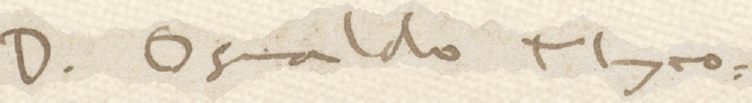

In [20]:
encoding = val_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)



labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)



image = Image.open(val_dataset.root_dir + val_df['file_name'][0]).convert("RGB")
image


In [21]:
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    # Separate the input features and labels in the batch
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Pad the sequences to have the same length
    pixel_values_padded = pad_sequence(pixel_values, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)

    # Return the padded batch as a dictionary
    return {"pixel_values": pixel_values_padded, "labels": labels_padded}

# Dataloaders

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
eval_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)


# Config model

In [23]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.to(device)



Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [24]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

# Metric


In [25]:
from datasets import load_metric

wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

<ipython-input-25-fb0986f8b54e>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


In [26]:
def compute_wer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return wer
def compute_cer(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer

# Finetune

In [27]:
from datetime import datetime#, strftime

datetime.now().strftime("%B_%d_%Y-%H:%M:%S")

'July_07_2023-03:30:27'

In [ ]:
EPOCHS = 50

from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

accumulation_steps = 4  # Adjust this value based on your desired effective batch size

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for i, batch in enumerate(tqdm(train_dataloader)):
        for k, v in batch.items():
            batch[k] = v.to(device)

        outputs = model(**batch)
        loss = outputs.loss
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps

    print(f"Loss after epoch {epoch}:", train_loss / len(train_dataloader))

    # evaluate
    model.eval()
    valid_wer = 0.0
    valid_cer = 0.0
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            # run batch generation
            outputs = model.generate(batch["pixel_values"].to(device))
            # compute metrics
            wer = compute_wer(pred_ids=outputs, label_ids=batch["labels"])
            valid_wer += wer
            cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
            valid_cer += cer
    print("testing wer:", valid_wer / len(eval_dataloader))
    print("testing wer:", valid_cer / len(eval_dataloader))
model.save_pretrained(f'./datetime.now().strftime("%B_%d_%Y-%H:%M:%S")/')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 0: 5.999457565091905


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1259: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


testing wer: 1.1014730473397099
testing wer: 0.8237357023076822


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 1: 4.35032659910974


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 1.005600636320112
testing wer: 0.6426351288998976


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 2: 3.1554906662730944


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.7626234720201874
testing wer: 0.43540951837455016


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 3: 2.7164918464564143


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.7856190386506944
testing wer: 0.48605584593466683


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 4: 2.296719267254784


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.7854373474872195
testing wer: 0.4580954502659531


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 5: 1.7125828044400329


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6783636511519042
testing wer: 0.33741240114609217


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 6: 1.0482586234630573


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5927372343200055
testing wer: 0.27280514162787717


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 7: 0.7954523407277607


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.600104804272645
testing wer: 0.29010558025530725


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 8: 0.5874228522713695


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5935952517751923
testing wer: 0.2738067747191976


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 9: 0.7149426884771812


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6729552448711997
testing wer: 0.33094938059410905


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 10: 0.9293960582110143


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6450378040338707
testing wer: 0.31153385280177703


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 11: 0.518411126874742


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6212274565266658
testing wer: 0.3086843184568465


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 12: 0.33454980696773245


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5647502403840265
testing wer: 0.2673866589044246


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 13: 0.2386622118674928


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5695037033367812
testing wer: 0.26085379025032546


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 14: 0.2110161637399523


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5744375539105833
testing wer: 0.2664365095232171


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 15: 0.22258675912217724


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5555559134941395
testing wer: 0.25030895532439


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 16: 0.38430375259901794


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6353792666536711
testing wer: 0.3240187438542431


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 17: 0.6369125519746116


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6341862609388529
testing wer: 0.30082156943148325


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 18: 0.28961527640266077


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5692977984189694
testing wer: 0.28016810034193373


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 19: 0.21898386999964714


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5642133423409287
testing wer: 0.25094819625132536


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 20: 0.17745488303314363


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5575261828610188
testing wer: 0.2540902406906329


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 21: 0.1585144780443183


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5651530679650103
testing wer: 0.24273538172142178


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 22: 0.15324781515768596


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.5620135353427546
testing wer: 0.2543993420152473


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 23: 0.3862071881913358


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.7085942057036573
testing wer: 0.38655375491780686


  0%|          | 0/336 [00:00<?, ?it/s]

Loss after epoch 24: 0.4977822574742493


  0%|          | 0/25 [00:00<?, ?it/s]

testing wer: 0.6259229718733512
testing wer: 0.32535963898518405


  0%|          | 0/336 [00:00<?, ?it/s]